Simulation script to evaluate how well we can recover feature representation from Gaussian process search.   
Author: Allen Ross

## Setup

In [2]:
# Libraries
import gpflow
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
# import helper_functions as hfns
from helper_functions import *
import os
import itertools
# from tqdm import tdqm
from joblib import Parallel, delayed
import time
import pickle

# Options
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
tf.get_logger().setLevel('ERROR')
# tf.config.set_visible_devices([], 'GPU')
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [3]:
# Functions
def sim_data(rate=12, num_units=30, fixed_num=False,
             include_output=False, kern_out=None,
             eps=0, set_seed=True):
    # Set random seed
    if set_seed:
        np.random.seed(9102)

    # Assign treatment group to each unit
    # treat_group = np.repeat([0,1], num_units/2)
    treat_group = np.random.binomial(n=1, p=0.5, size=num_units)

    # Sample number of observations for each unit
    if fixed_num:
        num_obs = np.repeat(rate, num_units)
    else:
        num_obs = np.random.poisson(lam=rate, size=num_units)

    # Sample from uniform distribution for observation times
    x = np.concatenate(
        [np.sort(np.round(np.random.uniform(low=0, high=12, size=i), 1)) for i in num_obs],
        axis=0
    )

    # Put unit ID and observation time together
    df = np.array([np.repeat(np.arange(num_units), num_obs),
                   np.repeat(treat_group, num_obs),
                   x]).T

    df = pd.DataFrame(
        df,
        columns=['id', 'treat', 'time']
    )

    # Standardize continuous variable
    # df.time = (df.time - df.time.mean()) / df.time.std()

    if include_output and kern_out is not None:

        for k in kern_out.keys():
            # Simulate output
            f_ = np.random.multivariate_normal(
                mean=np.zeros_like(df.iloc[:, 0]).flatten(),
                cov=kern_out[k]['model'](df) + 1e-6 * np.eye(df.shape[0]),
                size=1
            )[0]

            # Add noise
            df[k] = f_ + np.random.normal(loc=0, scale=eps, size=len(f_))

    return df


def run_simulation(rate, epsilon, units, iters, kernel_list):
    
    tf.get_logger().setLevel('ERROR')
    
    # Prep output dataset
    sim_out = pd.DataFrame()

    # Build temporary simulated data
    temp_df = sim_data(
        rate=rate,
        num_units=units,
        include_output=True,
        kern_out=kernel_dictionary,
        set_seed=False,
        eps=epsilon
    )

    # Run kernel search process
    for i in range(4):
        search_out = split_kernel_search(
            X=temp_df[['id', 'treat', 'time']],
            Y=temp_df.drop(columns=['id', 'treat', 'time']).iloc[:, i],
            kern_list=kernel_list,
            cat_vars=[0, 1],
            unit_idx=0,
            max_depth=5,
            early_stopping=True,
            prune=True,
            keep_all=False,
            keep_only_best=True,
            lik='gaussian',
            random_seed=9102,
            metric_diff=1  # 3,  # 0
            )

        # Save resulting kernels and information
        cur_out = pd.DataFrame({
            'rate': [rate],  # 4*[r],
            'eps': [epsilon],  # 4*[eps],
            'units': [units],  # 4*[u],
            'iter': [iters],  # 4*[i],
            'output': ['y'+str(i)],  # ['y1', 'y2', 'y3', 'y4'],
            'kernel': [search_out['best_model']],  # [x['best_model'] for x in search_out],
            'model': [search_out['models'][search_out['best_model']]]
            # [x['models'][x['best_model']] for x in search_out]
        })

        sim_out = pd.concat([sim_out, cur_out])
        # print(f"Finished rate {r} with {u} units and epsilon {eps}")
        # print(f"Took {round((time.time() - start_time)/60, 1)} minutes")

    return sim_out.reset_index(drop=True)

## Kernel specifications

In [16]:
# First kernel is just a simple time varying covariance structure + unit offset
k1 = (gpflow.kernels.Matern12(variance=1.0,
                              lengthscales=1.0,
                              active_dims=[2]) +
      Categorical(variance=2.0,
                       active_dims=[0]))

# Second kernel is time varying unit specific effect + periodic overall effect
k2 = (gpflow.kernels.Matern12(variance=1.0,
                              lengthscales=0.5,
                              active_dims=[2]) *
      Categorical(active_dims=[0], variance=1.0) +
      gpflow.kernels.Periodic(
          base_kernel=gpflow.kernels.SquaredExponential(
              variance=2.0, active_dims=[2]),
          period=3.0))

# Third kernel is random unit specific effect + treatment effect
k3 = (Categorical(active_dims=[0], variance=2.0) +
      Categorical(active_dims=[1], variance=1.0) *
      gpflow.kernels.Linear(variance=1.0,
                            active_dims=[2]))

# Fourth kernel is nonlinear random treatment effect over time +
# nonlinear individual effect over time
k4 = (Categorical(active_dims=[0], variance=0.5) +
      Categorical(active_dims=[1], variance=1.0) *
      gpflow.kernels.Polynomial(degree=1,
                                offset=3.,
                                variance=1.0,
                                active_dims=[2]) +
      Categorical(active_dims=[0], variance=1.0) *
      gpflow.kernels.SquaredExponential(variance=2.0,
                                        lengthscales=0.5,
                                        active_dims=[2]))

# Kernel dictionary
kernel_dictionary = {
    'y1': {'model': k1},
    'y2': {'model': k2},
    'y3': {'model': k3},
    'y4': {'model': k4}
}

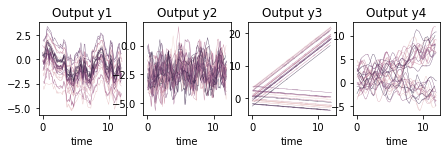

In [17]:
# Sample from kernels to inspect potential output
samp_df = sim_data(rate=100,
                   num_units=30,
                   fixed_num=True,
                   include_output=True,
                   kern_out=kernel_dictionary,
                   set_seed=True)

# Plot resulting output
f, axs = plt.subplots(1, len(kernel_dictionary), figsize=(7.2, 1.7))
for i, k in enumerate(kernel_dictionary.keys()):
    p = sns.lineplot(data=samp_df,
                     x='time',
                     y=k,
                     hue='id',
                     legend=False,
                     alpha=0.9,
                     linewidth=0.35,
                     ax=axs[i])
    p.set_title(f'Output {k}')
    #if i != 0:
    p.set_ylabel('')
    p.plot()

In [5]:
samp_df.to_csv('simulated_data_full.csv', index=False)

## Simulation

In [17]:
# Set options
np.random.seed(9102)
rates = [3, 6, 9]  # [3, 9] #[2, 4, 12] #[5, 10, 20]
units = [10, 30, 50]  # [10, 50, 100] #[10, 30, 50]
epsilons = [0.1, 1, 10]
iters = 100 # 50
sim_settings = list(
    itertools.product(*[rates, epsilons, units, list(range(0, iters))])
)
# Shuffle options for more even parallel processing
np.random.shuffle(sim_settings)
# Set kernel search list
kernel_list = [
    gpflow.kernels.SquaredExponential(),
    gpflow.kernels.Matern12(),
    gpflow.kernels.Linear(),
    gpflow.kernels.Polynomial(),
    gpflow.kernels.ArcCosine(),
    gpflow.kernels.Periodic(base_kernel=gpflow.kernels.SquaredExponential())
]

# Run simulation
start_time = time.time()
with tqdm_joblib(tqdm(desc="Simulation", total=len(sim_settings))) as progress_bar:
    sim_out = Parallel(n_jobs=8, verbose=1)(
        delayed(run_simulation)(
            rate=r,
            epsilon=e,
            units=u,
            iters=i,
            kernel_list=kernel_list
        )
        for r, e, u, i in sim_settings
    )

# Collapse output
sim_results = pd.concat(sim_out)
end_time = time.time()
print("---%.2f seconds---" % (end_time-start_time))
# 10 iters = 1:44:40

# Save output
f = open("sim_results.pkl", "wb")
pickle.dump(sim_results, f)
f.close()

Simulation:   2%|▊                                                   | 42/2700 [10:59<16:23:52, 22.21s/it]/Users/allen/miniforge3/envs/gpflow/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Simulation: 100%|██████████████████████████████████████████████████| 2700/2700 [10:18:46<00:00, 13.75s/it]


---37127.11 seconds---


In [18]:
sim_results = pickle.load(open( "sim_results.pkl", "rb" ))

In [19]:
sim_results

,rate,eps,units,iter,output,kernel,model
0,6,1.0,30,4,y0,categorical[0]+matern12[2],{'kernel': <gpflow.kernels.base.Sum object at ...
1,6,1.0,30,4,y1,squared_exponential[2],{'kernel': <gpflow.kernels.stationaries.Square...
2,6,1.0,30,4,y2,categorical[0]+categorical[1]*linear[2],{'kernel': <gpflow.kernels.base.Sum object at ...
3,6,1.0,30,4,y3,categorical[1]*polynomial[2],{'kernel': <gpflow.kernels.base.Product object...
0,9,10.0,10,79,y0,constant,{'kernel': <gpflow.kernels.statics.Constant ob...
...,...,...,...,...,...,...,...
3,9,10.0,10,48,y3,constant,{'kernel': <gpflow.kernels.statics.Constant ob...
0,9,1.0,50,20,y0,categorical[0]+matern12[2],{'kernel': <gpflow.kernels.base.Sum object at ...
1,9,1.0,50,20,y1,squared_exponential[2],{'kernel': <gpflow.kernels.stationaries.Square...
2,9,1.0,50,20,y2,categorical[0]+categorical[1]*linear[2],{'kernel': <gpflow.kernels.base.Sum object at ...


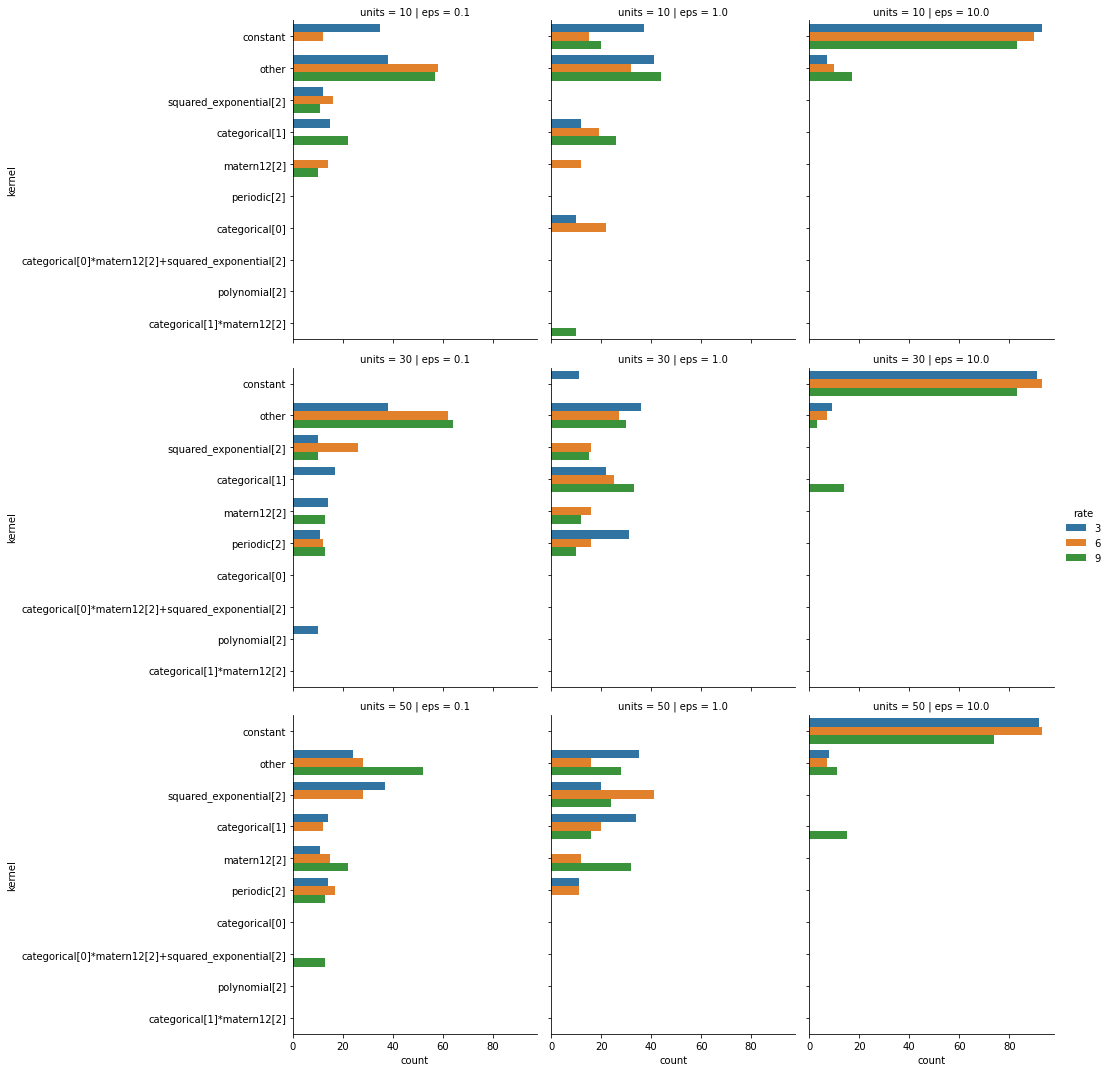

In [20]:
# Reformat and visualize output
true_kernels = pd.DataFrame({
    'output': ['y1', 'y2', 'y3', 'y4'],
    'kernel': ['categorical[0]+matern12[2]',
        'categorical[0]*matern12[2]+periodic[2]',
        'categorical[0]+categorical[1]*linear[2]',
        'categorical[0]*squared_exponential[2]+categorical[1]*polynomial[2]']
})

# Split final kernels, expand to each row, and then count number of occurrences
sim_results['kernel_parts'] = [x.split('+') for x in sim_results.kernel]
sim_results_long = sim_results.drop(columns=['kernel', 'model']).explode('kernel_parts')
# sim_results_long_agg = sim_results_long. \
    # groupby(['rate', 'eps', 'output', 'kernel_parts']). \

sim_results_long_agg = sim_results. \
    groupby(['rate', 'eps', 'output', 'units', 'kernel']). \
    size(). \
    reset_index(name='count'). \
    sort_values('count', ascending=False)
# Bucket unlikely results together
# sim_results_long_agg. \
#     loc[(sim_results_long_agg['count'] < 5).values, 'kernel_parts'] = 'other'
sim_results_long_agg. \
    loc[(sim_results_long_agg['count'] < 10).values, 'kernel'] = 'other'
    
# groupby(['rate', 'eps', 'output', 'kernel_parts']). \
sim_results_long_agg = sim_results_long_agg. \
    groupby(['rate', 'eps', 'output', 'units', 'kernel']). \
    sum(). \
    reset_index(). \
    sort_values('count', ascending=False)

sns.catplot(
    data=sim_results_long_agg.query("output == 'y1'"),
    x='count',
    # y='kernel_parts',
    y='kernel',
    col='eps', #'output',
    hue='rate',
    row='units', #'output', #'eps',
    kind='bar',
    # row_order=['y1', 'y2', 'y3', 'y4'],
    # sharey=False
);

In [21]:
sim_results_top_k_plot_data.head(10)

NameError: name 'sim_results_top_k_plot_data' is not defined

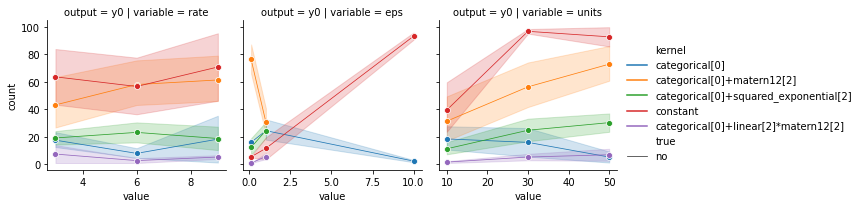

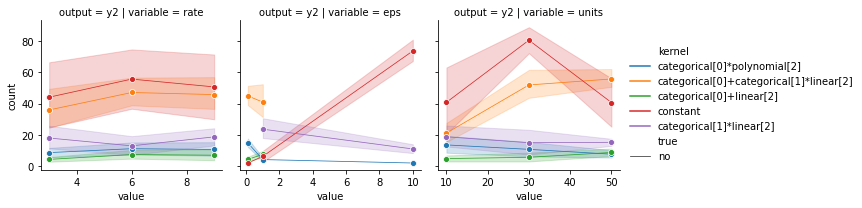

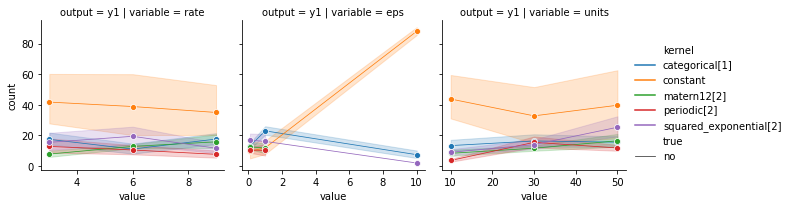

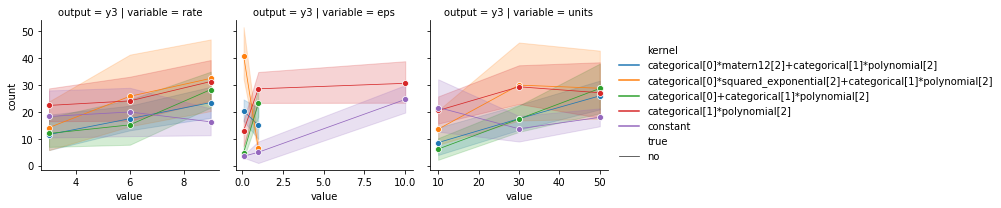

In [22]:
# Gather the top 5 kernels for each output
top_kernels = sim_results.\
    groupby(['output', 'kernel'], as_index=False).\
    size().\
    sort_values('size', ascending=False).\
    groupby(['output']).\
    head(5).\
    merge(true_kernels.assign(true='yes'), on=['output', 'kernel'], how='left').\
    fillna('no')

# First we want to get the number of times a kernel shows up for each set of parameters
# Then we want to get the number of times a kernel shows up at all for an output (to subset to most common)
# And finally then we want to subset to the top 5 kernels for each output
sim_results_top_k_plot_data = sim_results. \
    groupby(['rate', 'eps', 'output', 'units', 'kernel']). \
    size(). \
    reset_index(name='count'). \
    sort_values('count', ascending=False).\
    merge(top_kernels, on=['output', 'kernel'], how='inner')

for y in sim_results_long_agg.output.unique():
    grid = sns.FacetGrid(
        sim_results_top_k_plot_data. \
            query("output == '"+y+"'"). \
            groupby(['rate', 'eps', 'output', 'units', 'kernel', 'true']). \
            sum(). \
            unstack(fill_value=0). \
            stack(). \
            reset_index(). \
            melt(id_vars=['kernel', 'count', 'output', 'true'], value_vars=['rate', 'eps', 'units']),
        col="variable",
        row="output",
        sharex=False,
    )

    grid.map(
        sns.lineplot,
        "value",
        "count",
        "kernel",
        "true",
        marker='o',
        #sizes=[1,3],
        seed=9102,
        n_boot=500,
        ci=80
    )

    grid.add_legend()

    plt.show()


In [30]:
sim_results.reset_index(inplace=True)

In [32]:
sim_results['lik_variance'] = [sim_results['model'][x]['model'].likelihood.variance.numpy().flatten()[0] for x in range(sim_results.shape[0])]

In [33]:
sim_results.head()

,index,rate,eps,units,iter,output,kernel,model,kernel_parts,lik_variance
0,0,6,1.0,30,4,y0,categorical[0]+matern12[2],{'kernel': <gpflow.kernels.base.Sum object at ...,"[categorical[0], matern12[2]]",0.908780
1,1,6,1.0,30,4,y1,squared_exponential[2],{'kernel': <gpflow.kernels.stationaries.Square...,[squared_exponential[2]],1.736631
2,2,6,1.0,30,4,y2,categorical[0]+categorical[1]*linear[2],{'kernel': <gpflow.kernels.base.Sum object at ...,"[categorical[0], categorical[1]*linear[2]]",1.117206
3,3,6,1.0,30,4,y3,categorical[1]*polynomial[2],{'kernel': <gpflow.kernels.base.Product object...,[categorical[1]*polynomial[2]],2.396616
4,0,9,10.0,10,79,y0,constant,{'kernel': <gpflow.kernels.statics.Constant ob...,[constant],113.516731


In [34]:
sim_results.assign(units = sim_results.units.apply(str))

,index,rate,eps,units,iter,output,kernel,model,kernel_parts,lik_variance
0,0,6,1.0,30,4,y0,categorical[0]+matern12[2],{'kernel': <gpflow.kernels.base.Sum object at ...,"[categorical[0], matern12[2]]",0.908780
1,1,6,1.0,30,4,y1,squared_exponential[2],{'kernel': <gpflow.kernels.stationaries.Square...,[squared_exponential[2]],1.736631
2,2,6,1.0,30,4,y2,categorical[0]+categorical[1]*linear[2],{'kernel': <gpflow.kernels.base.Sum object at ...,"[categorical[0], categorical[1]*linear[2]]",1.117206
3,3,6,1.0,30,4,y3,categorical[1]*polynomial[2],{'kernel': <gpflow.kernels.base.Product object...,[categorical[1]*polynomial[2]],2.396616
4,0,9,10.0,10,79,y0,constant,{'kernel': <gpflow.kernels.statics.Constant ob...,[constant],113.516731
...,...,...,...,...,...,...,...,...,...,...
10795,3,9,10.0,10,48,y3,constant,{'kernel': <gpflow.kernels.statics.Constant ob...,[constant],88.849938
10796,0,9,1.0,50,20,y0,categorical[0]+matern12[2],{'kernel': <gpflow.kernels.base.Sum object at ...,"[categorical[0], matern12[2]]",0.863203
10797,1,9,1.0,50,20,y1,squared_exponential[2],{'kernel': <gpflow.kernels.stationaries.Square...,[squared_exponential[2]],2.138675
10798,2,9,1.0,50,20,y2,categorical[0]+categorical[1]*linear[2],{'kernel': <gpflow.kernels.base.Sum object at ...,"[categorical[0], categorical[1]*linear[2]]",1.039686


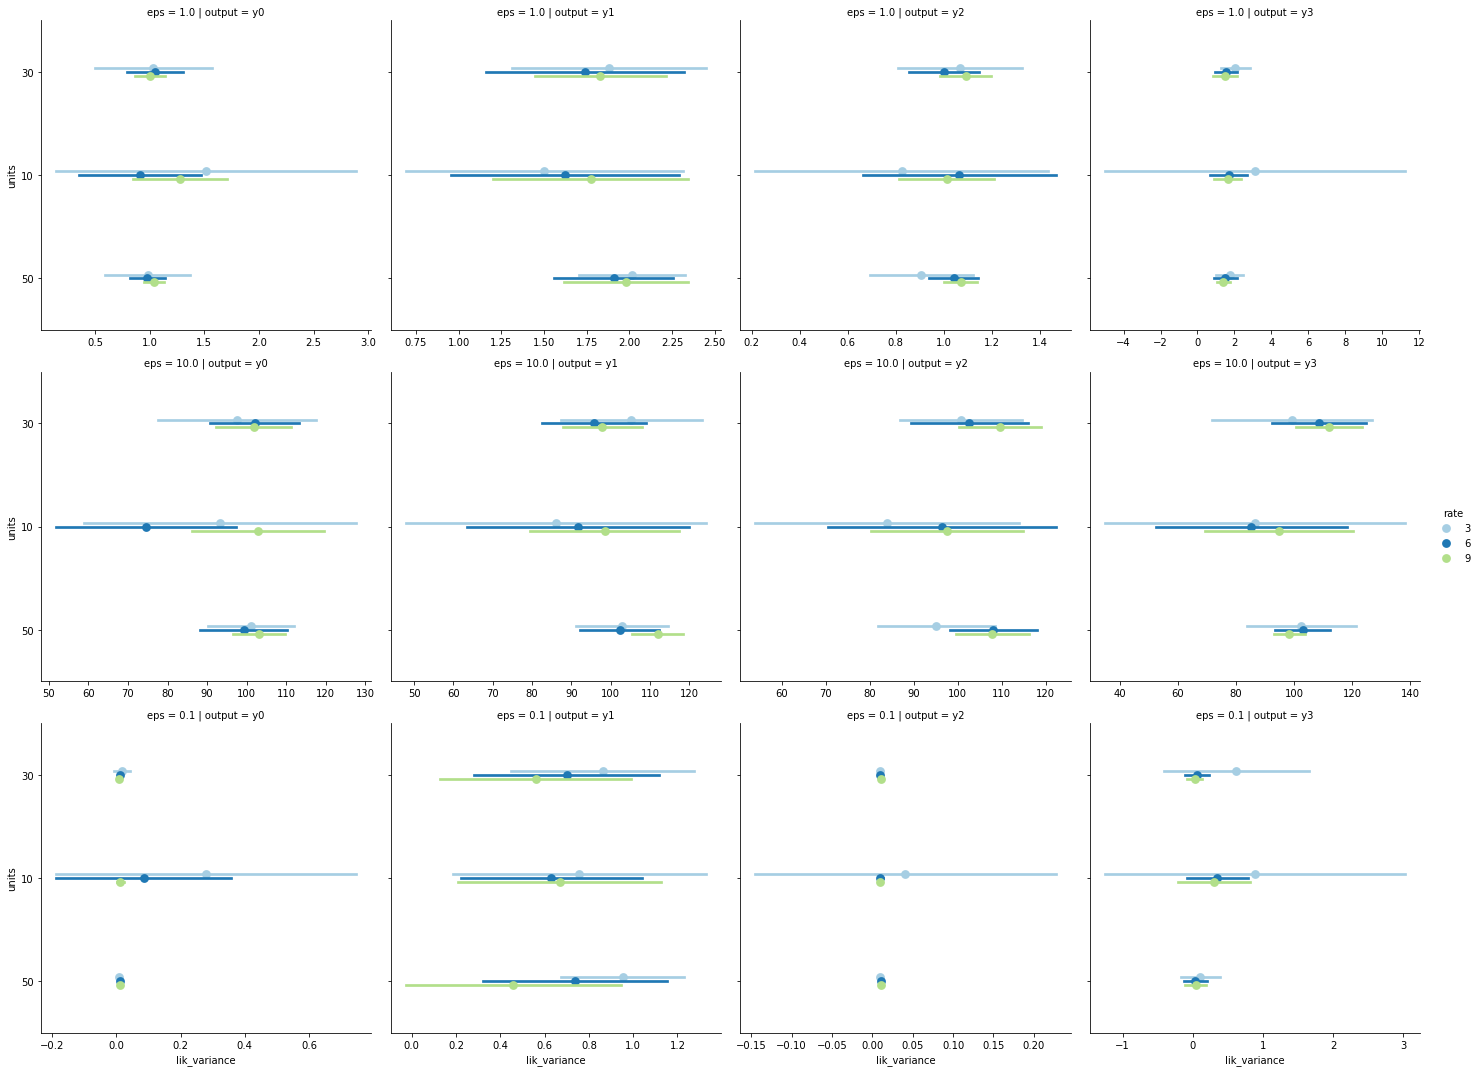

In [46]:
sns.catplot(
    x="lik_variance", 
    y="units",
    hue="rate", 
    col="output",
    row="eps",
    data=sim_results.assign(units = sim_results.units.apply(str),
                            eps = sim_results.eps.apply(str)), 
    kind="point",
    dodge=True,
    # n_boot=50,
    ci='sd',
    sharex=False,
    join=False,
    palette='Paired'
);

### Individual splitting

In [4]:
samp_df = sim_data(rate=20,
                   num_units=50,
                   fixed_num=True,
                   include_output=True,
                   kern_out=kernel_dictionary,
                   set_seed=True,
                   eps=0.1)

In [5]:
samp_df

,id,treat,time,y1,y2,y3,y4
0,0.0,0.0,0.8,-0.403505,-1.740430,0.219321,1.558011
1,0.0,0.0,1.0,-0.384368,-2.016143,0.306913,2.082773
2,0.0,0.0,1.5,-1.146688,-1.203751,0.571485,1.434307
3,0.0,0.0,2.7,0.143024,-2.152576,0.915007,0.713268
4,0.0,0.0,2.8,0.566962,-2.382068,1.091982,0.837487
...,...,...,...,...,...,...,...
995,49.0,1.0,9.5,-0.388479,-3.050735,-1.324360,11.831224
996,49.0,1.0,10.1,1.039816,-2.195747,-1.469057,13.943111
997,49.0,1.0,10.8,0.680261,-0.306518,-1.654922,16.570543
998,49.0,1.0,11.4,0.141867,-1.354302,-1.834372,21.272711


In [ ]:
# from gpflow.optimizers import Adam, NaturalGradient
m_test = gpflow.models.GPR(
    data = (samp_df[['id', 'treat', 'time']].to_numpy().reshape(-1, 3), samp_df['y1'].to_numpy().reshape(-1, 1)),
    kernel = Categorical(active_dims=[0])+gpflow.kernels.Matern12(active_dims=[2])
)

# natgrad_opt = NaturalGradient(gamma=1.0)
# variational_params = [(vgp.q_mu, vgp.q_sqrt)]
# natgrad_opt.minimize(vgp.training_loss, var_list=variational_params)

for i in range(1000):
    tf.optimizers.Adam(learning_rate=0.1, epsilon=0.1).minimize(m_test.training_loss, m_test.trainable_variables)
    # natgrad_opt.minimize(m_test.training_loss, m_test.trainable_variables)
    likelihood = m_test.training_loss()
    # adam_opt_for_vgp.minimize(vgp.training_loss, var_list=vgp.trainable_variables)
    # likelihood = vgp.elbo()
    if i % 50 == 0:
        tf.print(f"GRP Likelihood Loss with Adam: iteration {i + 1} likelihood {likelihood:.04f}")

In [46]:
%%time
split_results = [split_kernel_search(
    X=samp_df[['id', 'treat', 'time']],
    Y=samp_df['y'+str(x)],
    cat_vars=[0, 1],
    random_seed=9102,
    unit_idx=0,
    kern_list=[
        gpflow.kernels.SquaredExponential(),
        gpflow.kernels.Matern12(),
        gpflow.kernels.Linear(),
        gpflow.kernels.Polynomial(),
        gpflow.kernels.Periodic(base_kernel=gpflow.kernels.SquaredExponential())
    ],
    verbose=True,
    keep_only_best=True,
    prune=True
) for x in range(1,5)]

Working on depth 1 now
-----------

Working on depth 2 now
-----------

Working on depth 3 now
No better kernel found in layer, exiting search!
Pruning now
categorical[0]+matern12[2]
Working on depth 1 now
-----------

Working on depth 2 now
-----------

Working on depth 3 now
-----------

Working on depth 4 now
No better kernel found in layer, exiting search!
Pruning now
New best log likelihood: -1005.7397843393464
New best log likelihood: -1005.7397843349992
Model: ['periodic', 'categorical'], BIC: 2037.68
categorical[0]*matern12[2]+periodic[2]
Working on depth 1 now
-----------

Working on depth 2 now
-----------

Working on depth 3 now
No better kernel found in layer, exiting search!
Pruning now
categorical[0]*polynomial[2]
Working on depth 1 now
-----------

Working on depth 2 now
-----------

Working on depth 3 now
-----------

Working on depth 4 now
-----------

Working on depth 5 now
No better kernel found in layer, exiting search!
Pruning now
New best log likelihood: -1016.813

In [8]:
%%time
split_y1_new = split_kernel_search(
    X=samp_df[['id', 'treat', 'time']],
    Y=samp_df['y1'],
    cat_vars=[0, 1],
    random_seed=9102,
    unit_idx=0,
    kern_list=[gpflow.kernels.SquaredExponential(), gpflow.kernels.Matern12()],
    verbose=True,
    # debug=True,
    keep_only_best=False,
    prune=True,
    metric_diff=10
)

Working on depth 1 now
-----------

Working on depth 2 now


/Users/allen/Documents/Academics/GW/research/projects/waveome/kernel_learning/helper_functions.py:678: RuntimeWarning: overflow encountered in exp
  return np.exp(x)


-----------

Working on depth 3 now
No better kernel found in layer, exiting search!
Pruning now
categorical[0]+matern12[2]
CPU times: user 2min 45s, sys: 27.5 s, total: 3min 12s
Wall time: 1min 5s


In [9]:
[(k, x['bic']) for k, x in split_y1_new['models'].items()]

[('categorical[0]', 2354.72),
 ('constant', 2919.79),
 ('categorical[1]', 2902.25),
 ('squared_exponential[2]', 2654.31),
 ('matern12[2]', 2661.27),
 ('categorical[0]+categorical[1]', 2361.21),
 ('categorical[0]+squared_exponential[2]', -122.58),
 ('categorical[0]+matern12[2]', -348.73),
 ('categorical[0]*categorical[1]', 2354.72),
 ('categorical[0]*squared_exponential[2]', 1879.07),
 ('categorical[0]*matern12[2]', 1685.65),
 ('categorical[0]+matern12[2]+categorical[1]', -342.18),
 ('categorical[0]+matern12[2]+squared_exponential[2]', -344.05),
 ('categorical[0]+categorical[0]*matern12[2]', 1666.5),
 ('categorical[0]*categorical[1]+matern12[2]', -348.73),
 ('categorical[0]+categorical[1]*matern12[2]', -8.95),
 ('categorical[0]*squared_exponential[2]+matern12[2]', inf),
 ('categorical[0]+matern12[2]*squared_exponential[2]', inf),
 ('categorical[0]*matern12[2]+matern12[2]', -331.41),
 ('categorical[0]+matern12[2]*matern12[2]', -342.18)]

In [37]:
split_y1_new['models'][split_y1_new['best_model']]['model']

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.kernels[0].variance,Parameter,Softplus,Gamma,True,(),float64,2.08416
GPR.kernel.kernels[1].variance,Parameter,Softplus,Gamma,True,(),float64,1.21849
GPR.kernel.kernels[1].lengthscales,Parameter,Softplus,Gamma,True,(),float64,1.07529
GPR.likelihood.variance,Parameter,Softplus + Shift,Gamma,True,(),float64,0.0101846


In [38]:
split_y1['models'][split_y1['best_model']]['model']

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,2.34031
GPR.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,1.78816
GPR.kernel.kernels[1].lengthscales,Parameter,Softplus,,True,(),float64,1.60845
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.0101858


In [7]:
%%time
split_y1 = split_kernel_search(
    X=samp_df[['id', 'treat', 'time']],
    Y=samp_df['y1'],
    cat_vars=[0, 1],
    random_seed=9102,
    unit_idx=0,
    kern_list=[gpflow.kernels.SquaredExponential(), gpflow.kernels.Matern12()],
    verbose=True,
    keep_only_best=False,
    prune=True
)

Working on depth 1 now
-----------

Working on depth 2 now
-----------

Working on depth 3 now
No better kernel found in layer, exiting search!
Pruning now
categorical[0]+matern12[2]
CPU times: user 3min 1s, sys: 48.3 s, total: 3min 49s
Wall time: 1min 21s


In [9]:
split_y1['best_model']

'categorical[0]+matern12[2]'

/Users/allen/miniforge3/envs/gp/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/allen/miniforge3/envs/gp/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


<AxesSubplot:xlabel='time'>

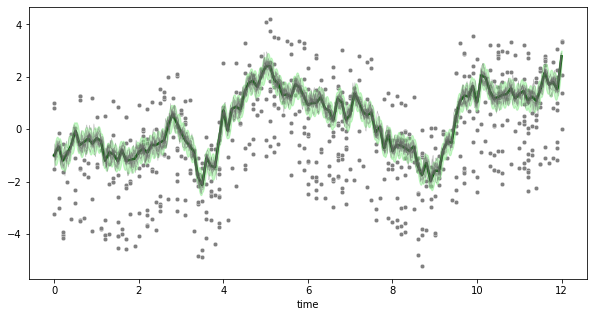

In [10]:
gp_predict_fun(split_y1['models'][split_y1['best_model']]['model'], 2, 0, ['id','treat','time'])

/Users/allen/miniforge3/envs/gp/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/allen/miniforge3/envs/gp/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


(<Figure size 1080x360 with 3 Axes>,
 array([<AxesSubplot:title={'center':'categorical[id] (57.0%)'}, xlabel='time'>,
        <AxesSubplot:title={'center':'matern12[time] (43.0%)'}, xlabel='time'>,
        <AxesSubplot:title={'center':'residuals (0.0%)'}, xlabel='time'>],
       dtype=object))

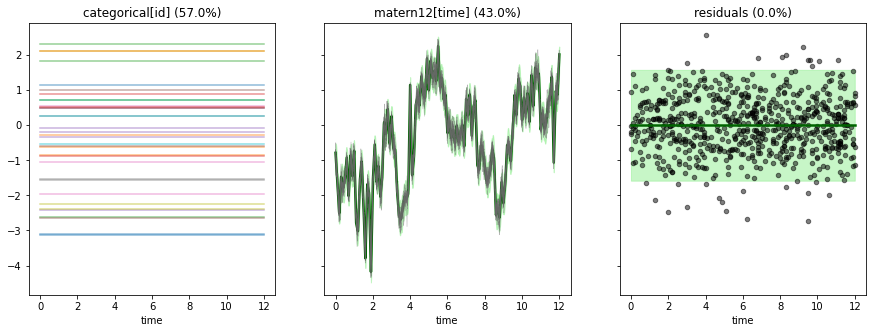

In [11]:
pred_kernel_parts(
    m=split_y1['models'][split_y1['best_model']]['model'], 
    k_names=split_y1['best_model'],
    time_idx=2, 
    unit_idx=0, 
    col_names=['id','treat','time']
)

In [44]:
kernel_list = [
    gpflow.kernels.SquaredExponential(),
    gpflow.kernels.Matern12(),
    gpflow.kernels.Linear(),
    gpflow.kernels.Polynomial(),
    #gpflow.kernels.ArcCosine(),
    gpflow.kernels.Periodic(base_kernel=gpflow.kernels.SquaredExponential())
]

split_out = Parallel(n_jobs=4, verbose=1)(
    delayed(split_kernel_search)(
        X=samp_df[['id', 'treat', 'time']],
        Y=samp_df.drop(columns=['id', 'treat', 'time']).iloc[:, i],
        kern_list=kernel_list,
        cat_vars=[0, 1],
        unit_idx=0,
        max_depth=5,
        early_stopping=True,
        prune=True,
        keep_all=False,
        keep_only_best=False,
        lik='gaussian',
        random_seed=9102,
        num_restarts=3
    )
    for i in range(4)
)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Metal device set to: Apple M1 Pro
Metal device set to: Apple M1 Pro
Metal device set to: Apple M1 Pro
Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed: 29.6min remaining: 29.6min



systemMemory: 16.00 GB
maxCacheSize: 5.33 GB


systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed: 41.9min finished



systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



In [126]:
kernel_list = [
    gpflow.kernels.SquaredExponential(),
    gpflow.kernels.Matern12(),
    gpflow.kernels.Linear(),
    #gpflow.kernels.Polynomial(),
    #gpflow.kernels.ArcCosine(),
    gpflow.kernels.Periodic(base_kernel=gpflow.kernels.SquaredExponential())
]

split_out = Parallel(n_jobs=4, verbose=1)(
    delayed(split_kernel_search)(
        X=samp_df[['id', 'treat', 'time']],
        Y=samp_df.drop(columns=['id', 'treat', 'time']).iloc[:, i],
        kern_list=kernel_list,
        cat_vars=[0, 1],
        unit_idx=0,
        max_depth=5,
        early_stopping=True,
        prune=True,
        keep_all=False,
        keep_only_best=False,
        lik='gaussian',
        random_seed=9102,
        num_restarts=1
    )
    for i in range(4)
)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed: 57.9min remaining: 57.9min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed: 79.9min finished


In [127]:
[split_out[x]['best_model'] for x in range(4)]

['categorical[0]+matern12[2]',
 'categorical[0]*matern12[2]+categorical[0]*matern12[2]+periodic[2]',
 'categorical[0]*squared_exponential[2]+categorical[0]*linear[2]+linear[2]',
 'categorical[0]*squared_exponential[2]+categorical[1]*squared_exponential[2]']

In [6]:
%%time
y2_search = split_kernel_search(
    X=samp_df[['id', 'treat', 'time']],
    Y=samp_df.drop(columns=['id', 'treat', 'time']).iloc[:, 1],
    kern_list=[
        gpflow.kernels.SquaredExponential(),
        gpflow.kernels.Matern12(),
        gpflow.kernels.Linear(),
        gpflow.kernels.Polynomial(),
        gpflow.kernels.Periodic(base_kernel=gpflow.kernels.SquaredExponential())
    ],
    cat_vars=[0, 1],
    unit_idx=0,
    max_depth=5,
    early_stopping=True,
    prune=True,
    keep_all=False,
    keep_only_best=False,
    lik='gaussian',
    random_seed=9102
)

CPU times: user 11min 54s, sys: 3min 26s, total: 15min 20s
Wall time: 4min 48s


In [7]:
y2_search['best_model']

'categorical[0]*matern12[2]+periodic[2]'

In [8]:
y2_search['models'][y2_search['best_model']]['model']

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.kernels[0].kernels[0].variance,Parameter,Softplus,,False,(),float64,1
GPR.kernel.kernels[0].kernels[1].variance,Parameter,Softplus,,True,(),float64,2.89528
GPR.kernel.kernels[0].kernels[1].lengthscales,Parameter,Softplus,,True,(),float64,1.8039
GPR.kernel.kernels[1].base_kernel.variance,Parameter,Softplus,,True,(),float64,2.68225
GPR.kernel.kernels[1].base_kernel.lengthscales,Parameter,Softplus,,True,(),float64,2.85359
GPR.kernel.kernels[1].period,Parameter,Softplus,,True,(),float64,3.07532
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.00668504


In [38]:
k2

name,class,transform,prior,trainable,shape,dtype,value
Sum.kernels[0].kernels[0].variance,Parameter,Softplus,,True,(),float64,1
Sum.kernels[0].kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,0.5
Sum.kernels[0].kernels[1].variance,Parameter,Softplus,,True,(),float64,1
Sum.kernels[1].base_kernel.variance,Parameter,Softplus,,True,(),float64,2
Sum.kernels[1].base_kernel.lengthscales,Parameter,Softplus,,True,(),float64,1
Sum.kernels[1].period,Parameter,Softplus,,True,(),float64,3


/Users/allen/miniforge3/envs/gp/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/allen/miniforge3/envs/gp/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


(<Figure size 1080x360 with 3 Axes>,
 array([<AxesSubplot:title={'center':'categorical[id]*matern12[time] (52.0%)'}, xlabel='time'>,
        <AxesSubplot:title={'center':'periodic[time] (48.0%)'}, xlabel='time'>,
        <AxesSubplot:title={'center':'residuals (0.0%)'}, xlabel='time'>],
       dtype=object))

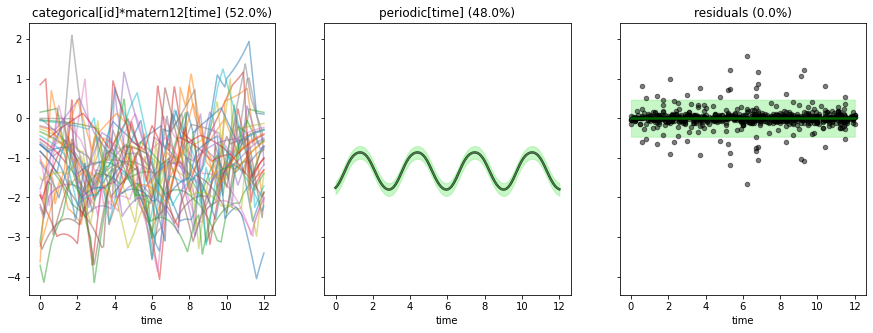

In [9]:
pred_kernel_parts(
    m=y2_search['models'][y2_search['best_model']]['model'],
    k_names=y2_search['best_model'],
    time_idx=2,
    unit_idx=0,
    col_names=['id', 'treat', 'time']
)

In [11]:
[split_out[x]['best_model'] for x in range(4)]

['categorical[0]+matern12[2]',
 'categorical[0]*matern12[2]+matern12[2]',
 'categorical[0]*squared_exponential[2]+categorical[1]*linear[2]',
 'categorical[0]*matern12[2]+categorical[1]*squared_exponential[2]']

In [12]:
split_out[3]['models'][split_out[3]['best_model']]['model']

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.kernels[0].kernels[0].variance,Parameter,Softplus,,False,(),float64,1
GPR.kernel.kernels[0].kernels[1].variance,Parameter,Softplus,,True,(),float64,108.293
GPR.kernel.kernels[0].kernels[1].lengthscales,Parameter,Softplus,,True,(),float64,54.675
GPR.kernel.kernels[1].kernels[0].variance,Parameter,Softplus,,True,(),float64,1219.68
GPR.kernel.kernels[1].kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,9.88015
GPR.kernel.kernels[1].kernels[1].variance,Parameter,Softplus,,False,(),float64,1
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.0101662


(<Figure size 1080x360 with 3 Axes>,
 array([<AxesSubplot:title={'center':'categorical[id]*squared_exponential[time] (100.0%)'}, xlabel='time'>,
        <AxesSubplot:title={'center':'categorical[treat]*linear[time] (0.0%)'}, xlabel='time'>,
        <AxesSubplot:title={'center':'residuals (0.0%)'}, xlabel='time'>],
       dtype=object))

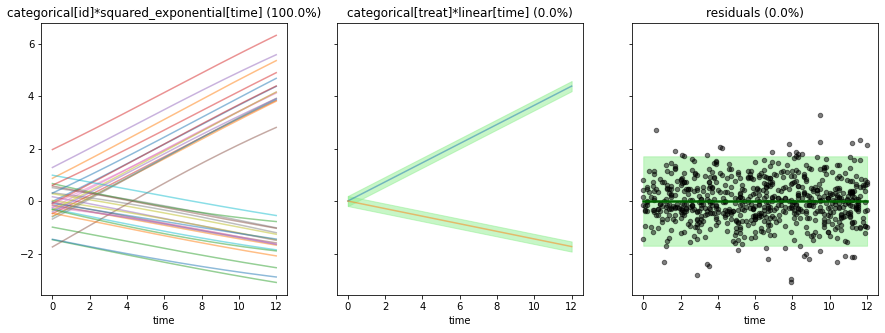

In [13]:
pred_kernel_parts(
    m=split_out[2]['models'][split_out[2]['best_model']]['model'],
    k_names=split_out[2]['best_model'],
    time_idx=2,
    unit_idx=0,
    col_names=['id', 'treat', 'time']
)

### Sparse approximation

In [11]:
X_test = samp_df.iloc[:, :3].to_numpy().reshape(-1, 3)
Y_test = samp_df['y4'].to_numpy().reshape(-1, 1)
X_iv = samp_df.groupby('id').sample(n=10).iloc[:, :3].to_numpy().reshape(-1, 3)

In [12]:
# Get five observations per individual unit ID
iv_idx = np.concatenate([np.random.choice(np.asarray(X_test[:, 0] == i).nonzero()[0], size=10, replace=False) for i in np.unique(X_test[:, 0])])

In [13]:
%%time
# create SVGP model as usual and optimize
m = gpflow.models.SGPR(data=(X_test, Y_test),
                   # kernel=gpflow.kernels.Linear(active_dims=[2])*Categorical(active_dims=[1])+Categorical(active_dims=[0]),
                   kernel=(Categorical(active_dims=[0]) +
      Categorical(active_dims=[1]) *
      gpflow.kernels.Polynomial(active_dims=[2]) +
      Categorical(active_dims=[0]) *
      gpflow.kernels.SquaredExponential(active_dims=[2])),
                   inducing_variable=X_test[iv_idx, :].copy())
opt_results = gpflow.optimizers.Scipy().minimize(
    m.training_loss,
    m.trainable_variables
)
print_summary(m)

╒════════════════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤══════════╤═════════╤════════════════════════╕
│ name                                           │ class     │ transform        │ prior   │ trainable   │ shape    │ dtype   │ value                  │
╞════════════════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪══════════╪═════════╪════════════════════════╡
│ SGPR.kernel.kernels[0].variance                │ Parameter │ Softplus         │         │ True        │ ()       │ float64 │ 0.45405370936198924    │
├────────────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼──────────┼─────────┼────────────────────────┤
│ SGPR.kernel.kernels[1].kernels[0].variance     │ Parameter │ Softplus         │         │ True        │ ()       │ float64 │ 0.30122298139773834    │
├────────────────────────────────────────────────┼───────────┼──────────────────┼───────

<AxesSubplot:xlabel='c'>

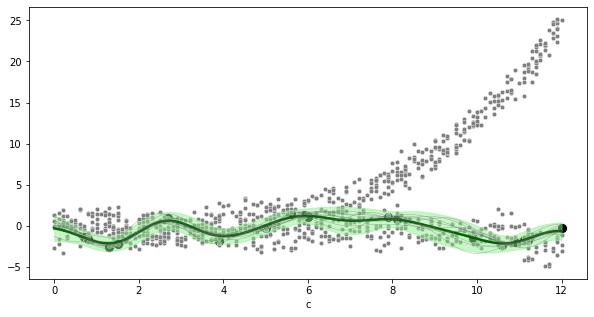

In [14]:
gp_predict_fun(gp=m, x_idx=2, unit_idx=0, col_names=['a', 'b', 'c'], unit_label=1)
#plt.plot(X_test[:50, 2], np.repeat(0, 50), 'o')
#plt.plot(m.inducing_variable.Z.numpy()[:, 2], np.repeat(0, 50), 'o')

In [15]:
%%time
# Try same model without inducing points
m2 = gpflow.models.GPR(data=(X_test, Y_test),
                       # kernel=gpflow.kernels.Linear(active_dims=[2])*Categorical(active_dims=[1])+Categorical(active_dims=[0])
                        kernel=(Categorical(active_dims=[0]) +
      Categorical(active_dims=[1]) *
      gpflow.kernels.Polynomial(active_dims=[2]) +
      Categorical(active_dims=[0]) *
      gpflow.kernels.SquaredExponential(active_dims=[2])),
                      )
print_summary(m2)
opt_results = gpflow.optimizers.Scipy().minimize(
    m2.training_loss,
    m2.trainable_variables
)
print_summary(m2)

╒═══════════════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════╕
│ name                                          │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │   value │
╞═══════════════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═════════╡
│ GPR.kernel.kernels[0].variance                │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │       1 │
├───────────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ GPR.kernel.kernels[1].kernels[0].variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │       1 │
├───────────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ GPR.kernel.kernels[1].kernels[1].variance     │ Param

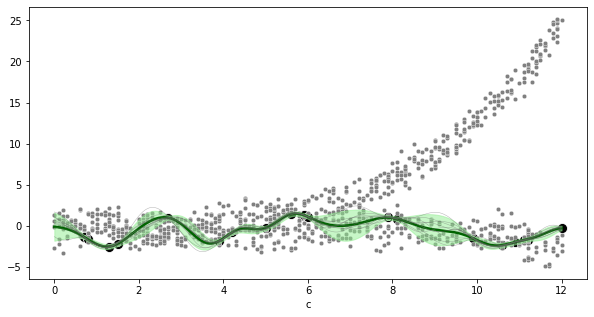

In [16]:
gp_predict_fun(gp=m2, x_idx=2, unit_idx=0, col_names=['a', 'b', 'c'], unit_label=1);

### Minibatching

In [113]:
%%time
m = gpflow.models.SVGP(#data=(X_test, Y_test),
                    likelihood=gpflow.likelihoods.Gaussian(),
                   kernel=gpflow.kernels.SquaredExponential(active_dims=[2]) + Categorical(active_dims=[0]),
                   inducing_variable=X_test.copy()
)
# opt_results = gpflow.optimizers.Scipy().minimize(
#     m.training_loss,
#     m.trainable_variables
# )
# m
tensor_data = tuple(map(tf.convert_to_tensor, (X_test, Y_test)))
m.elbo(tensor_data) 

CPU times: user 105 ms, sys: 9.68 ms, total: 115 ms
Wall time: 78.8 ms


<tf.Tensor: shape=(), dtype=float64, numpy=-1737.5039280012993>

In [ ]:
%%time
minibatch_size = 100
train_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test)).repeat()#.shuffle(500)
train_iter = iter(train_dataset.batch(minibatch_size))
m.elbo(next(train_iter))

CPU times: user 76.9 ms, sys: 17.6 ms, total: 94.5 ms
Wall time: 62.4 ms


<tf.Tensor: shape=(), dtype=float64, numpy=-430.1403144310118>

In [118]:
minibatch_size = 100

# We turn off training for inducing point locations
#gpflow.set_trainable(m.inducing_variable, False)


def run_adam(model, iterations):
    """
    Utility function running the Adam optimizer
    
    :param model: GPflow model
    :param interations: number of iterations
    """
    # Create an Adam Optimizer action
    logf = []
    train_iter = iter(train_dataset.batch(minibatch_size))
    training_loss = model.training_loss_closure(train_iter, compile=True)
    optimizer = tf.optimizers.Adam()

    @tf.function
    def optimization_step():
        optimizer.minimize(training_loss, model.trainable_variables)

    for step in range(iterations):
        optimization_step()
        if step % 10 == 0:
            elbo = -training_loss().numpy()
            logf.append(elbo)
    return logf

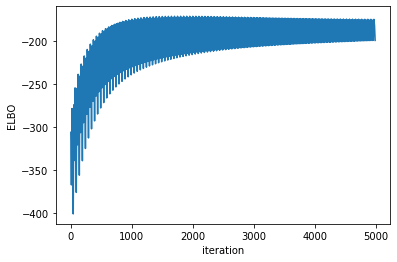

In [119]:
maxiter = ci_niter(5000)

logf = run_adam(m, maxiter)
plt.plot(np.arange(maxiter)[::10], logf)
plt.xlabel("iteration")
_ = plt.ylabel("ELBO")

In [120]:
m

name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,0.866906807246735
SVGP.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,1.5840634905771478
SVGP.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,0.7041212551438445
SVGP.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.6801200098280655
SVGP.inducing_variable.Z,Parameter,Identity,,True,"(500, 3)",float64,"[[0., 0., 0.24718353..."
SVGP.q_mu,Parameter,Identity,,True,"(500, 1)",float64,[[-7.97627348e-01...
SVGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 500, 500)",float64,"[[[5.91291451e-01, 0.00000000e+00, 0.00000000e+00..."


<AxesSubplot:>

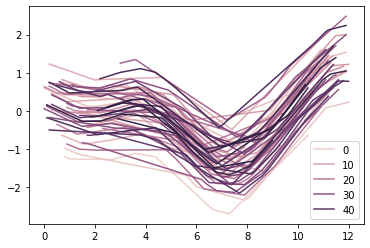

In [122]:
mu, var = m.predict_f(X_test)
# plt.plot(X_test[:, 2], mu, 'o')
sns.lineplot(x=X_test[:, 2],
             y=mu.numpy().flatten(),
             hue=X_test[:, 0])

In [132]:
Y_test.shape

(500, 1)

### ARD prefiltering

In [15]:
X_test = samp_df.iloc[:, :3].to_numpy().reshape(-1, 3)
Y_test = samp_df['y4'].to_numpy().reshape(-1, 1)

(X_test - X_test.min(axis=0))/(X_test.max(axis=0) - X_test.min(axis=0))

array([[0.        , 0.        , 0.06666667],
       [0.        , 0.        , 0.08333333],
       [0.        , 0.        , 0.125     ],
       ...,
       [1.        , 1.        , 0.9       ],
       [1.        , 1.        , 0.95      ],
       [1.        , 1.        , 0.98333333]])


systemMemory: 16.00 GB
maxCacheSize: 5.33 GB


systemMemory: 16.00 GB
maxCacheSize: 5.33 GB


systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



In [33]:
# k4 = (Categorical(active_dims=[0], variance=0.5) +
#       Categorical(active_dims=[1], variance=0.001) *
#       gpflow.kernels.Polynomial(degree=2,
#                                 offset=3.,
#                                 variance=1.,
#                                 active_dims=[2]) +
#       Categorical(active_dims=[0]) *
#       gpflow.kernels.SquaredExponential(variance=1.,
#                                         lengthscales=0.5,
#                                         active_dims=[2]))

X_test = samp_df.iloc[:, :3].to_numpy().reshape(-1, 3)
Y_test = samp_df['y4'].to_numpy().reshape(-1, 1)
m_ard = gpflow.models.GPR(
    data=((X_test - X_test.min(axis=0))/(X_test.max(axis=0) - X_test.min(axis=0)), Y_test),
    kernel=gpflow.kernels.SquaredExponential(lengthscales=3*[1.], active_dims=[0,1,2]) + 
    Categorical(active_dims=[1]) +
      # Categorical(active_dims=[1]) *
    gpflow.kernels.Polynomial(active_dims=[2])
        #gpflow.kernels.Matern12(active_dims=[2]) + Categorical(active_dims=[0])
)

# m_ard.kernel.variance.prior = tfd.Uniform(0, 5) #f64(0), f64(1))
# m_ard.kernel.lengthscales.prior = tfd.Gamma(1,1)

In [34]:
m_ard

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,1.0
GPR.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,"(3,)",float64,[1. 1. 1.]
GPR.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,1.0
GPR.kernel.kernels[2].variance,Parameter,Softplus,,True,(),float64,1.0
GPR.kernel.kernels[2].offset,Parameter,Softplus,,True,(),float64,1.0
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0


In [41]:
m_ard.kernel.trainable_parameters[0].transform_fn(-1.)

<tf.Tensor: shape=(), dtype=float32, numpy=0.3132617>

In [35]:
%%time
opt_results = gpflow.optimizers.Scipy().minimize(
    m_ard.training_loss,
    m_ard.trainable_variables
)

InvalidArgumentError: 2 root error(s) found.
  (0) INVALID_ARGUMENT:  Input matrix is not invertible.
	 [[node triangular_solve/MatrixTriangularSolve
 (defined at /Users/allen/miniforge3/envs/gp/lib/python3.8/site-packages/gpflow/logdensities.py:97)
]]
	 [[gradient_tape/add_12/Sum_1/_66]]
  (1) INVALID_ARGUMENT:  Input matrix is not invertible.
	 [[node triangular_solve/MatrixTriangularSolve
 (defined at /Users/allen/miniforge3/envs/gp/lib/python3.8/site-packages/gpflow/logdensities.py:97)
]]
0 successful operations.
0 derived errors ignored. [Op:__inference__tf_eval_66142]

Errors may have originated from an input operation.
Input Source operations connected to node triangular_solve/MatrixTriangularSolve:
In[0] Cholesky (defined at /Users/allen/miniforge3/envs/gp/lib/python3.8/site-packages/gpflow/models/gpr.py:87)	
In[1] sub (defined at /Users/allen/miniforge3/envs/gp/lib/python3.8/site-packages/gpflow/logdensities.py:96)

Operation defined at: (most recent call last)
>>>   File "/Users/allen/miniforge3/envs/gp/lib/python3.8/runpy.py", line 194, in _run_module_as_main
>>>     return _run_code(code, main_globals, None,
>>> 
>>>   File "/Users/allen/miniforge3/envs/gp/lib/python3.8/runpy.py", line 87, in _run_code
>>>     exec(code, run_globals)
>>> 
>>>   File "/Users/allen/miniforge3/envs/gp/lib/python3.8/site-packages/ipykernel_launcher.py", line 16, in <module>
>>>     app.launch_new_instance()
>>> 
>>>   File "/Users/allen/miniforge3/envs/gp/lib/python3.8/site-packages/traitlets/config/application.py", line 846, in launch_instance
>>>     app.start()
>>> 
>>>   File "/Users/allen/miniforge3/envs/gp/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 677, in start
>>>     self.io_loop.start()
>>> 
>>>   File "/Users/allen/miniforge3/envs/gp/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 199, in start
>>>     self.asyncio_loop.run_forever()
>>> 
>>>   File "/Users/allen/miniforge3/envs/gp/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
>>>     self._run_once()
>>> 
>>>   File "/Users/allen/miniforge3/envs/gp/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
>>>     handle._run()
>>> 
>>>   File "/Users/allen/miniforge3/envs/gp/lib/python3.8/asyncio/events.py", line 81, in _run
>>>     self._context.run(self._callback, *self._args)
>>> 
>>>   File "/Users/allen/miniforge3/envs/gp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 461, in dispatch_queue
>>>     await self.process_one()
>>> 
>>>   File "/Users/allen/miniforge3/envs/gp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 450, in process_one
>>>     await dispatch(*args)
>>> 
>>>   File "/Users/allen/miniforge3/envs/gp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 357, in dispatch_shell
>>>     await result
>>> 
>>>   File "/Users/allen/miniforge3/envs/gp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 652, in execute_request
>>>     reply_content = await reply_content
>>> 
>>>   File "/Users/allen/miniforge3/envs/gp/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 359, in do_execute
>>>     res = shell.run_cell(code, store_history=store_history, silent=silent)
>>> 
>>>   File "/Users/allen/miniforge3/envs/gp/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 532, in run_cell
>>>     return super().run_cell(*args, **kwargs)
>>> 
>>>   File "/Users/allen/miniforge3/envs/gp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2768, in run_cell
>>>     result = self._run_cell(
>>> 
>>>   File "/Users/allen/miniforge3/envs/gp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2814, in _run_cell
>>>     return runner(coro)
>>> 
>>>   File "/Users/allen/miniforge3/envs/gp/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
>>>     coro.send(None)
>>> 
>>>   File "/Users/allen/miniforge3/envs/gp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3012, in run_cell_async
>>>     has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
>>> 
>>>   File "/Users/allen/miniforge3/envs/gp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3191, in run_ast_nodes
>>>     if await self.run_code(code, result, async_=asy):
>>> 
>>>   File "/Users/allen/miniforge3/envs/gp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3251, in run_code
>>>     exec(code_obj, self.user_global_ns, self.user_ns)
>>> 
>>>   File "/var/folders/2w/r7x976td4f97twg4r5ff50500000gn/T/ipykernel_30367/2850287274.py", line 1, in <module>
>>>     get_ipython().run_cell_magic('time', '', 'opt_results = gpflow.optimizers.Scipy().minimize(\n    m_ard.training_loss,\n    m_ard.trainable_variables\n)\n')
>>> 
>>>   File "/Users/allen/miniforge3/envs/gp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2257, in run_cell_magic
>>>     result = fn(*args, **kwargs)
>>> 
>>>   File "/Users/allen/miniforge3/envs/gp/lib/python3.8/site-packages/IPython/core/magics/execution.py", line 1316, in time
>>>     exec(code, glob, local_ns)
>>> 
>>>   File "<timed exec>", line 1, in <module>
>>> 
>>>   File "/Users/allen/miniforge3/envs/gp/lib/python3.8/site-packages/gpflow/optimizers/scipy.py", line 90, in minimize
>>>     return scipy.optimize.minimize(
>>> 
>>>   File "/Users/allen/miniforge3/envs/gp/lib/python3.8/site-packages/scipy/optimize/_minimize.py", line 681, in minimize
>>>     res = _minimize_lbfgsb(fun, x0, args, jac, bounds,
>>> 
>>>   File "/Users/allen/miniforge3/envs/gp/lib/python3.8/site-packages/scipy/optimize/_lbfgsb_py.py", line 308, in _minimize_lbfgsb
>>>     sf = _prepare_scalar_function(fun, x0, jac=jac, args=args, epsilon=eps,
>>> 
>>>   File "/Users/allen/miniforge3/envs/gp/lib/python3.8/site-packages/scipy/optimize/_optimize.py", line 263, in _prepare_scalar_function
>>>     sf = ScalarFunction(fun, x0, args, grad, hess,
>>> 
>>>   File "/Users/allen/miniforge3/envs/gp/lib/python3.8/site-packages/scipy/optimize/_differentiable_functions.py", line 158, in __init__
>>>     self._update_fun()
>>> 
>>>   File "/Users/allen/miniforge3/envs/gp/lib/python3.8/site-packages/scipy/optimize/_differentiable_functions.py", line 251, in _update_fun
>>>     self._update_fun_impl()
>>> 
>>>   File "/Users/allen/miniforge3/envs/gp/lib/python3.8/site-packages/scipy/optimize/_differentiable_functions.py", line 155, in update_fun
>>>     self.f = fun_wrapped(self.x)
>>> 
>>>   File "/Users/allen/miniforge3/envs/gp/lib/python3.8/site-packages/scipy/optimize/_differentiable_functions.py", line 137, in fun_wrapped
>>>     fx = fun(np.copy(x), *args)
>>> 
>>>   File "/Users/allen/miniforge3/envs/gp/lib/python3.8/site-packages/scipy/optimize/_optimize.py", line 76, in __call__
>>>     self._compute_if_needed(x, *args)
>>> 
>>>   File "/Users/allen/miniforge3/envs/gp/lib/python3.8/site-packages/scipy/optimize/_optimize.py", line 70, in _compute_if_needed
>>>     fg = self.fun(x, *args)
>>> 
>>>   File "/Users/allen/miniforge3/envs/gp/lib/python3.8/site-packages/gpflow/optimizers/scipy.py", line 113, in _eval
>>>     loss, grad = _tf_eval(tf.convert_to_tensor(x))
>>> 
>>>   File "/Users/allen/miniforge3/envs/gp/lib/python3.8/site-packages/gpflow/optimizers/scipy.py", line 106, in _tf_eval
>>>     loss, grads = _compute_loss_and_gradients(closure, variables)
>>> 
>>>   File "/Users/allen/miniforge3/envs/gp/lib/python3.8/site-packages/gpflow/optimizers/scipy.py", line 172, in _compute_loss_and_gradients
>>>     loss = loss_closure()
>>> 
>>>   File "/Users/allen/miniforge3/envs/gp/lib/python3.8/site-packages/gpflow/models/training_mixins.py", line 63, in training_loss
>>>     return self._training_loss()
>>> 
>>>   File "/Users/allen/miniforge3/envs/gp/lib/python3.8/site-packages/gpflow/models/model.py", line 56, in _training_loss
>>>     return -(self.maximum_log_likelihood_objective(*args, **kwargs) + self.log_prior_density())
>>> 
>>>   File "/Users/allen/miniforge3/envs/gp/lib/python3.8/site-packages/gpflow/models/gpr.py", line 67, in maximum_log_likelihood_objective
>>>     return self.log_marginal_likelihood()
>>> 
>>>   File "/Users/allen/miniforge3/envs/gp/lib/python3.8/site-packages/gpflow/models/gpr.py", line 91, in log_marginal_likelihood
>>>     log_prob = multivariate_normal(Y, m, L)
>>> 
>>>   File "/Users/allen/miniforge3/envs/gp/lib/python3.8/site-packages/gpflow/logdensities.py", line 97, in multivariate_normal
>>>     alpha = tf.linalg.triangular_solve(L, d, lower=True)
>>> 

Input Source operations connected to node triangular_solve/MatrixTriangularSolve:
In[0] Cholesky (defined at /Users/allen/miniforge3/envs/gp/lib/python3.8/site-packages/gpflow/models/gpr.py:87)	
In[1] sub (defined at /Users/allen/miniforge3/envs/gp/lib/python3.8/site-packages/gpflow/logdensities.py:96)

Operation defined at: (most recent call last)
>>>   File "/Users/allen/miniforge3/envs/gp/lib/python3.8/runpy.py", line 194, in _run_module_as_main
>>>     return _run_code(code, main_globals, None,
>>> 
>>>   File "/Users/allen/miniforge3/envs/gp/lib/python3.8/runpy.py", line 87, in _run_code
>>>     exec(code, run_globals)
>>> 
>>>   File "/Users/allen/miniforge3/envs/gp/lib/python3.8/site-packages/ipykernel_launcher.py", line 16, in <module>
>>>     app.launch_new_instance()
>>> 
>>>   File "/Users/allen/miniforge3/envs/gp/lib/python3.8/site-packages/traitlets/config/application.py", line 846, in launch_instance
>>>     app.start()
>>> 
>>>   File "/Users/allen/miniforge3/envs/gp/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 677, in start
>>>     self.io_loop.start()
>>> 
>>>   File "/Users/allen/miniforge3/envs/gp/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 199, in start
>>>     self.asyncio_loop.run_forever()
>>> 
>>>   File "/Users/allen/miniforge3/envs/gp/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
>>>     self._run_once()
>>> 
>>>   File "/Users/allen/miniforge3/envs/gp/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
>>>     handle._run()
>>> 
>>>   File "/Users/allen/miniforge3/envs/gp/lib/python3.8/asyncio/events.py", line 81, in _run
>>>     self._context.run(self._callback, *self._args)
>>> 
>>>   File "/Users/allen/miniforge3/envs/gp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 461, in dispatch_queue
>>>     await self.process_one()
>>> 
>>>   File "/Users/allen/miniforge3/envs/gp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 450, in process_one
>>>     await dispatch(*args)
>>> 
>>>   File "/Users/allen/miniforge3/envs/gp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 357, in dispatch_shell
>>>     await result
>>> 
>>>   File "/Users/allen/miniforge3/envs/gp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 652, in execute_request
>>>     reply_content = await reply_content
>>> 
>>>   File "/Users/allen/miniforge3/envs/gp/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 359, in do_execute
>>>     res = shell.run_cell(code, store_history=store_history, silent=silent)
>>> 
>>>   File "/Users/allen/miniforge3/envs/gp/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 532, in run_cell
>>>     return super().run_cell(*args, **kwargs)
>>> 
>>>   File "/Users/allen/miniforge3/envs/gp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2768, in run_cell
>>>     result = self._run_cell(
>>> 
>>>   File "/Users/allen/miniforge3/envs/gp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2814, in _run_cell
>>>     return runner(coro)
>>> 
>>>   File "/Users/allen/miniforge3/envs/gp/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
>>>     coro.send(None)
>>> 
>>>   File "/Users/allen/miniforge3/envs/gp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3012, in run_cell_async
>>>     has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
>>> 
>>>   File "/Users/allen/miniforge3/envs/gp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3191, in run_ast_nodes
>>>     if await self.run_code(code, result, async_=asy):
>>> 
>>>   File "/Users/allen/miniforge3/envs/gp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3251, in run_code
>>>     exec(code_obj, self.user_global_ns, self.user_ns)
>>> 
>>>   File "/var/folders/2w/r7x976td4f97twg4r5ff50500000gn/T/ipykernel_30367/2850287274.py", line 1, in <module>
>>>     get_ipython().run_cell_magic('time', '', 'opt_results = gpflow.optimizers.Scipy().minimize(\n    m_ard.training_loss,\n    m_ard.trainable_variables\n)\n')
>>> 
>>>   File "/Users/allen/miniforge3/envs/gp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2257, in run_cell_magic
>>>     result = fn(*args, **kwargs)
>>> 
>>>   File "/Users/allen/miniforge3/envs/gp/lib/python3.8/site-packages/IPython/core/magics/execution.py", line 1316, in time
>>>     exec(code, glob, local_ns)
>>> 
>>>   File "<timed exec>", line 1, in <module>
>>> 
>>>   File "/Users/allen/miniforge3/envs/gp/lib/python3.8/site-packages/gpflow/optimizers/scipy.py", line 90, in minimize
>>>     return scipy.optimize.minimize(
>>> 
>>>   File "/Users/allen/miniforge3/envs/gp/lib/python3.8/site-packages/scipy/optimize/_minimize.py", line 681, in minimize
>>>     res = _minimize_lbfgsb(fun, x0, args, jac, bounds,
>>> 
>>>   File "/Users/allen/miniforge3/envs/gp/lib/python3.8/site-packages/scipy/optimize/_lbfgsb_py.py", line 308, in _minimize_lbfgsb
>>>     sf = _prepare_scalar_function(fun, x0, jac=jac, args=args, epsilon=eps,
>>> 
>>>   File "/Users/allen/miniforge3/envs/gp/lib/python3.8/site-packages/scipy/optimize/_optimize.py", line 263, in _prepare_scalar_function
>>>     sf = ScalarFunction(fun, x0, args, grad, hess,
>>> 
>>>   File "/Users/allen/miniforge3/envs/gp/lib/python3.8/site-packages/scipy/optimize/_differentiable_functions.py", line 158, in __init__
>>>     self._update_fun()
>>> 
>>>   File "/Users/allen/miniforge3/envs/gp/lib/python3.8/site-packages/scipy/optimize/_differentiable_functions.py", line 251, in _update_fun
>>>     self._update_fun_impl()
>>> 
>>>   File "/Users/allen/miniforge3/envs/gp/lib/python3.8/site-packages/scipy/optimize/_differentiable_functions.py", line 155, in update_fun
>>>     self.f = fun_wrapped(self.x)
>>> 
>>>   File "/Users/allen/miniforge3/envs/gp/lib/python3.8/site-packages/scipy/optimize/_differentiable_functions.py", line 137, in fun_wrapped
>>>     fx = fun(np.copy(x), *args)
>>> 
>>>   File "/Users/allen/miniforge3/envs/gp/lib/python3.8/site-packages/scipy/optimize/_optimize.py", line 76, in __call__
>>>     self._compute_if_needed(x, *args)
>>> 
>>>   File "/Users/allen/miniforge3/envs/gp/lib/python3.8/site-packages/scipy/optimize/_optimize.py", line 70, in _compute_if_needed
>>>     fg = self.fun(x, *args)
>>> 
>>>   File "/Users/allen/miniforge3/envs/gp/lib/python3.8/site-packages/gpflow/optimizers/scipy.py", line 113, in _eval
>>>     loss, grad = _tf_eval(tf.convert_to_tensor(x))
>>> 
>>>   File "/Users/allen/miniforge3/envs/gp/lib/python3.8/site-packages/gpflow/optimizers/scipy.py", line 106, in _tf_eval
>>>     loss, grads = _compute_loss_and_gradients(closure, variables)
>>> 
>>>   File "/Users/allen/miniforge3/envs/gp/lib/python3.8/site-packages/gpflow/optimizers/scipy.py", line 172, in _compute_loss_and_gradients
>>>     loss = loss_closure()
>>> 
>>>   File "/Users/allen/miniforge3/envs/gp/lib/python3.8/site-packages/gpflow/models/training_mixins.py", line 63, in training_loss
>>>     return self._training_loss()
>>> 
>>>   File "/Users/allen/miniforge3/envs/gp/lib/python3.8/site-packages/gpflow/models/model.py", line 56, in _training_loss
>>>     return -(self.maximum_log_likelihood_objective(*args, **kwargs) + self.log_prior_density())
>>> 
>>>   File "/Users/allen/miniforge3/envs/gp/lib/python3.8/site-packages/gpflow/models/gpr.py", line 67, in maximum_log_likelihood_objective
>>>     return self.log_marginal_likelihood()
>>> 
>>>   File "/Users/allen/miniforge3/envs/gp/lib/python3.8/site-packages/gpflow/models/gpr.py", line 91, in log_marginal_likelihood
>>>     log_prob = multivariate_normal(Y, m, L)
>>> 
>>>   File "/Users/allen/miniforge3/envs/gp/lib/python3.8/site-packages/gpflow/logdensities.py", line 97, in multivariate_normal
>>>     alpha = tf.linalg.triangular_solve(L, d, lower=True)
>>> 

Function call stack:
_tf_eval -> _tf_eval


In [30]:
print_summary(m_ard)

╒════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤════════════════════════════════════════════════╕
│ name                               │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value                                          │
╞════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪════════════════════════════════════════════════╡
│ GPR.kernel.kernels[0].variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 62.946429622530594                             │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────────────────────────────────────────┤
│ GPR.kernel.kernels[0].lengthscales │ Parameter │ Softplus         │         │ True        │ (3,)    │ float64 │ [1.15082714e+01 2.08711558e-04 2.15424860e-01] │
├─────────────────────

<AxesSubplot:xlabel='c'>

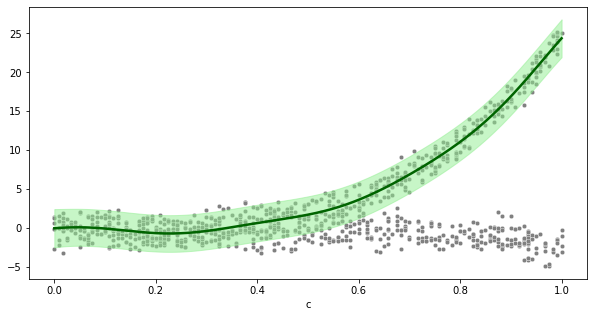

In [31]:
gp_predict_fun(gp=m_ard, x_idx=2, unit_idx=None, col_names=['a', 'b', 'c'])

In [25]:
# First round of ARD
m_ard.log_posterior_density()

<tf.Tensor: shape=(), dtype=float64, numpy=-1653.7203836597969>

In [32]:
# Second round of ARD
m_ard.log_posterior_density()

<tf.Tensor: shape=(), dtype=float64, numpy=-1653.2629687898418>

In [137]:
# Third round of ARD
m_ard.log_posterior_density()

<tf.Tensor: shape=(), dtype=float64, numpy=-4620.874654261973>

### LASSO prefiltering

In [72]:
m_lasso = gpflow.models.GPR(
    data=(X_test, Y_test),
    kernel=gpflow.kernels.Sum([gpflow.kernels.SquaredExponential(active_dims=[x]) for x in range(3)])
)
# Set priors
for p in m_lasso.kernel.parameters:
    p.prior = tfd.Laplace(f64(0), f64(1))

In [73]:
print_summary(m_lasso)

╒════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════╕
│ name                               │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │   value │
╞════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═════════╡
│ GPR.kernel.kernels[0].variance     │ Parameter │ Softplus         │ Laplace │ True        │ ()      │ float64 │       1 │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ GPR.kernel.kernels[0].lengthscales │ Parameter │ Softplus         │ Laplace │ True        │ ()      │ float64 │       1 │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ GPR.kernel.kernels[1].variance     │ Parameter │ Softplus         │ Laplace │ True        │ ()      │ float64 │       1 │
├───────

In [74]:
opt_results = gpflow.optimizers.Scipy().minimize(
    m_lassoå.training_loss,
    m_lasso.trainable_variables
)

In [76]:
print_summary(m_lasso)

╒════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════════╕
│ name                               │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │       value │
╞════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═════════════╡
│ GPR.kernel.kernels[0].variance     │ Parameter │ Softplus         │ Laplace │ True        │ ()      │ float64 │ 1.51376     │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────┤
│ GPR.kernel.kernels[0].lengthscales │ Parameter │ Softplus         │ Laplace │ True        │ ()      │ float64 │ 0.00623874  │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────┤
│ GPR.kernel.kernels[1].variance     │ Parameter │ Softplus         │ Laplace │ True        │ ()      │ 

### Adding Priors

In [16]:
samp_df

,id,treat,time,y1,y2,y3,y4
0,0.0,0.0,0.8,-0.403505,-1.740430,0.219321,1.558011
1,0.0,0.0,1.0,-0.384368,-2.016143,0.306913,2.082773
2,0.0,0.0,1.5,-1.146688,-1.203751,0.571485,1.434307
3,0.0,0.0,2.7,0.143024,-2.152576,0.915007,0.713268
4,0.0,0.0,2.8,0.566962,-2.382068,1.091982,0.837487
...,...,...,...,...,...,...,...
995,49.0,1.0,9.5,-0.388479,-3.050735,-1.324360,11.831224
996,49.0,1.0,10.1,1.039816,-2.195747,-1.469057,13.943111
997,49.0,1.0,10.8,0.680261,-0.306518,-1.654922,16.570543
998,49.0,1.0,11.4,0.141867,-1.354302,-1.834372,21.272711


In [18]:
k4

name,class,transform,prior,trainable,shape,dtype,value
Sum.kernels[0].variance,Parameter,Softplus,,True,(),float64,0.5
Sum.kernels[1].kernels[0].variance,Parameter,Softplus,,True,(),float64,0.0001
Sum.kernels[1].kernels[1].variance,Parameter,Softplus,,True,(),float64,1
Sum.kernels[1].kernels[1].offset,Parameter,Softplus,,True,(),float64,6
Sum.kernels[2].kernels[0].variance,Parameter,Softplus,,True,(),float64,1
Sum.kernels[2].kernels[1].variance,Parameter,Softplus,,True,(),float64,1
Sum.kernels[2].kernels[1].lengthscales,Parameter,Softplus,,True,(),float64,0.5


In [28]:
%%time
k = (Categorical(active_dims=[0]) + 
    Categorical(active_dims=[1])*gpflow.kernels.Polynomial(active_dims=[2]) + 
    Categorical(active_dims=[0])*gpflow.kernels.SquaredExponential(active_dims=[2]))
m_orig = kernel_test(
    X=samp_df[['id', 'treat', 'time']].to_numpy().reshape(-1, 3),
    Y=samp_df['y4'].to_numpy().reshape(-1, 1),
    k=k)

CPU times: user 41.6 s, sys: 8.84 s, total: 50.4 s
Wall time: 24.7 s


In [29]:
%%time
# Add priors
for p in k.parameters:
    p.prior = tfd.Gamma(f64(1),f64(1))
    
m_prior = kernel_test(
    X=samp_df[['id', 'treat', 'time']].to_numpy().reshape(-1, 3),
    Y=samp_df['y4'].to_numpy().reshape(-1, 1),
    k=k)

CPU times: user 53 s, sys: 10.6 s, total: 1min 3s
Wall time: 23.8 s


In [30]:
m_orig

(<gpflow.models.gpr.GPR object at 0x2861dc4c0>
╒═══════════════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤══════════╕
│ name                                          │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │    value │
╞═══════════════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪══════════╡
│ GPR.kernel.kernels[0].variance                │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.461597 │
├───────────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────┤
│ GPR.kernel.kernels[1].kernels[0].variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.419214 │
├───────────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────┤
│

In [31]:
m_prior

(<gpflow.models.gpr.GPR object at 0x28a6dec40>
╒═══════════════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═══════════╕
│ name                                          │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │     value │
╞═══════════════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═══════════╡
│ GPR.kernel.kernels[0].variance                │ Parameter │ Softplus         │ Gamma   │ True        │ ()      │ float64 │ 0.449698  │
├───────────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────────┤
│ GPR.kernel.kernels[1].kernels[0].variance     │ Parameter │ Softplus         │ Gamma   │ True        │ ()      │ float64 │ 0.140887  │
├───────────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────